In [1]:
# Importar las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)


# Cargar los datos
file_path = "C:/Users/ivan_/Documents/bootcamp/machine_learning/examen02/diabetes.csv"
diabetes_data = pd.read_csv(file_path)



In [2]:
# 1. Limpieza de Datos

## 1.1 Identificación y eliminación de valores duplicados
# Contar el número de registros duplicados
num_duplicados = diabetes_data.duplicated().sum()
print(f"Número de registros duplicados: {num_duplicados}")

# Eliminar registros duplicados si existen
if num_duplicados > 0:
    diabetes_data = diabetes_data.drop_duplicates()
    print("Registros duplicados eliminados.")
else:
    print("No se encontraron registros duplicados.")

## 1.2 Verificación y ajuste de tipos de datos
# Información inicial sobre los tipos de datos
print("\nInformación del dataset antes de ajustes:")
diabetes_data.info()

# Convertir columnas de tipo 'object' a numérico si es necesario
for column in diabetes_data.select_dtypes(include=['object']).columns:
    diabetes_data[column] = pd.to_numeric(diabetes_data[column], errors='coerce')

# Verificar nuevamente los tipos de datos
print("\nInformación del dataset después de ajustes:")
diabetes_data.info()

## 1.3 Corrección de inconsistencias en valores categóricos
# Verificar valores únicos en la columna 'Outcome'
print("\nValores únicos en 'Outcome' antes de ajustes:", diabetes_data['Outcome'].unique())

# Asegurarnos de que 'Outcome' contenga solo 0 y 1
diabetes_data['Outcome'] = diabetes_data['Outcome'].apply(
    lambda x: 1 if x == 'Positive' else (0 if x == 'Negative' else x)
)

# Convertir 'Outcome' a entero si es necesario
diabetes_data['Outcome'] = diabetes_data['Outcome'].astype(int)

# Verificar nuevamente los valores únicos
print("Valores únicos en 'Outcome' después de ajustes:", diabetes_data['Outcome'].unique())

## 1.4 Manejo de valores faltantes adecuadamente
# Imputación de ceros en columnas clave
columns_with_potential_issues = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Reemplazar valores cero por la mediana de los valores no cero
for column in columns_with_potential_issues:
    median_value = diabetes_data.loc[diabetes_data[column] != 0, column].median()
    diabetes_data[column] = diabetes_data[column].replace(0, median_value)
    print(f"Imputación realizada en {column} con la mediana: {median_value:.2f}")




Número de registros duplicados: 0
No se encontraron registros duplicados.

Información del dataset antes de ajustes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Información del dataset después de ajustes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data c

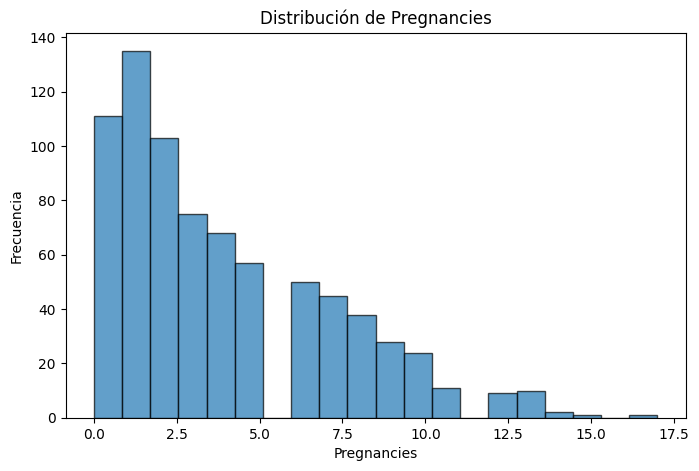

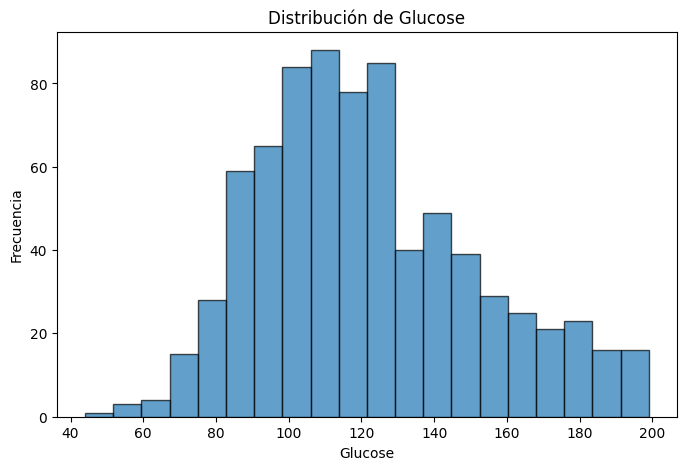

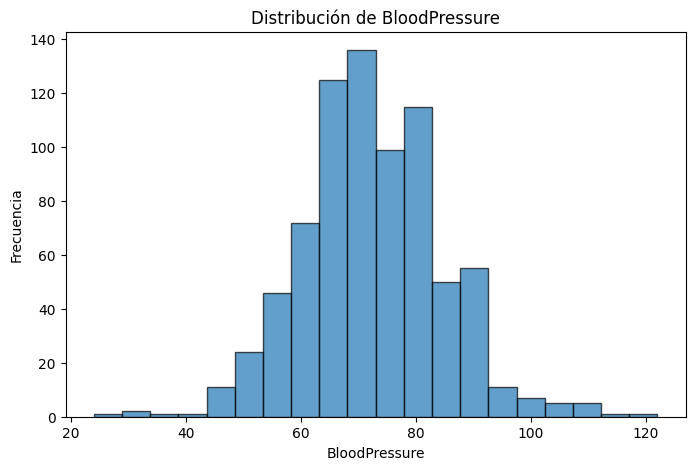

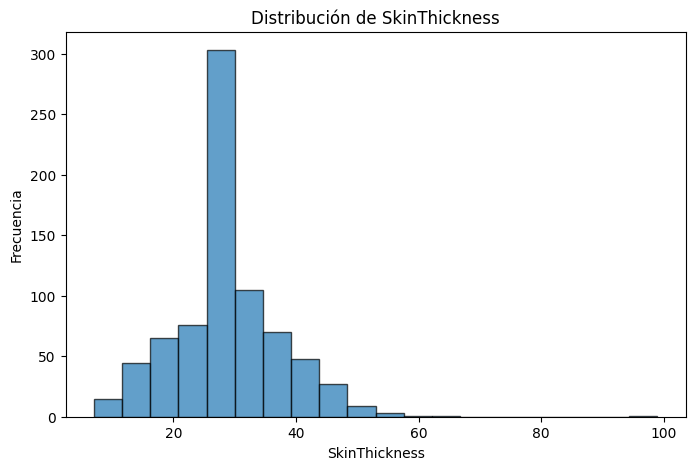

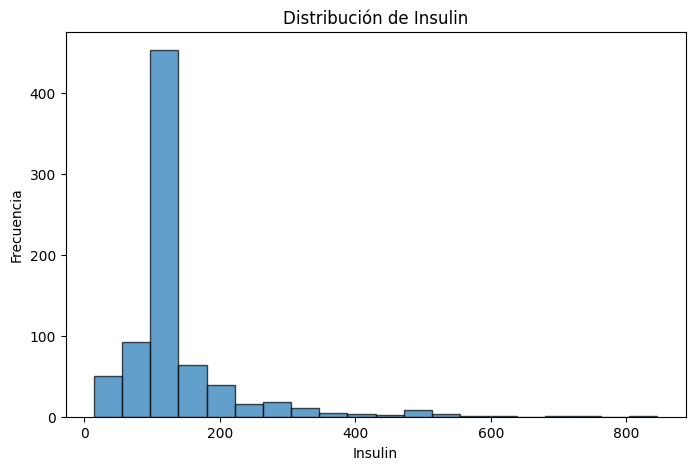

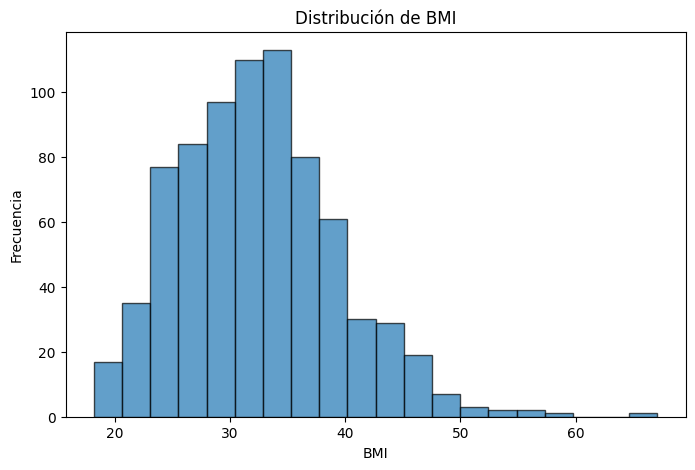

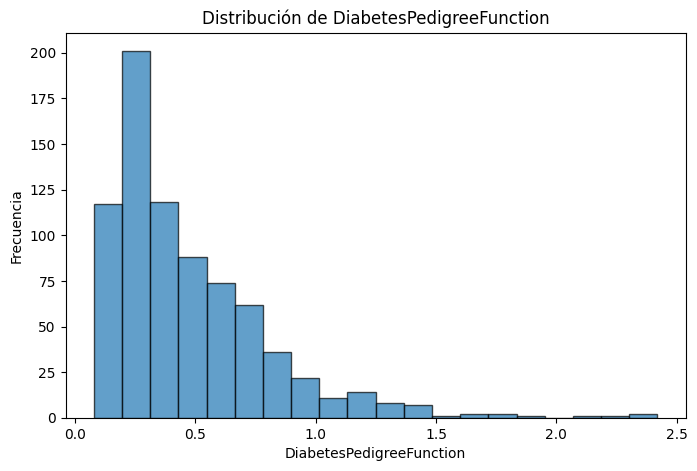

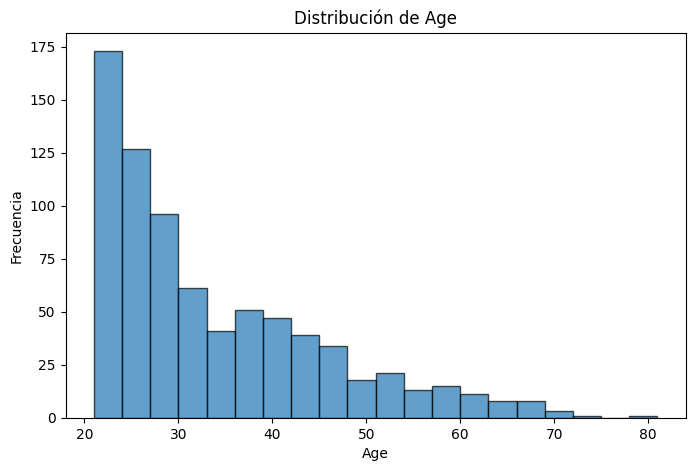

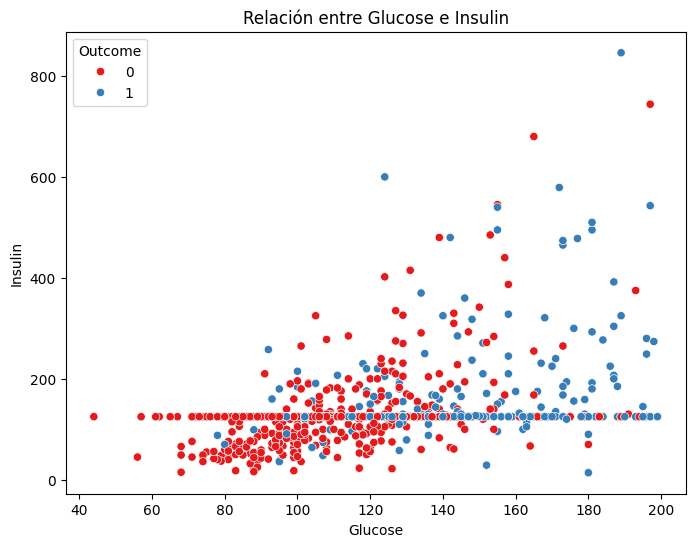

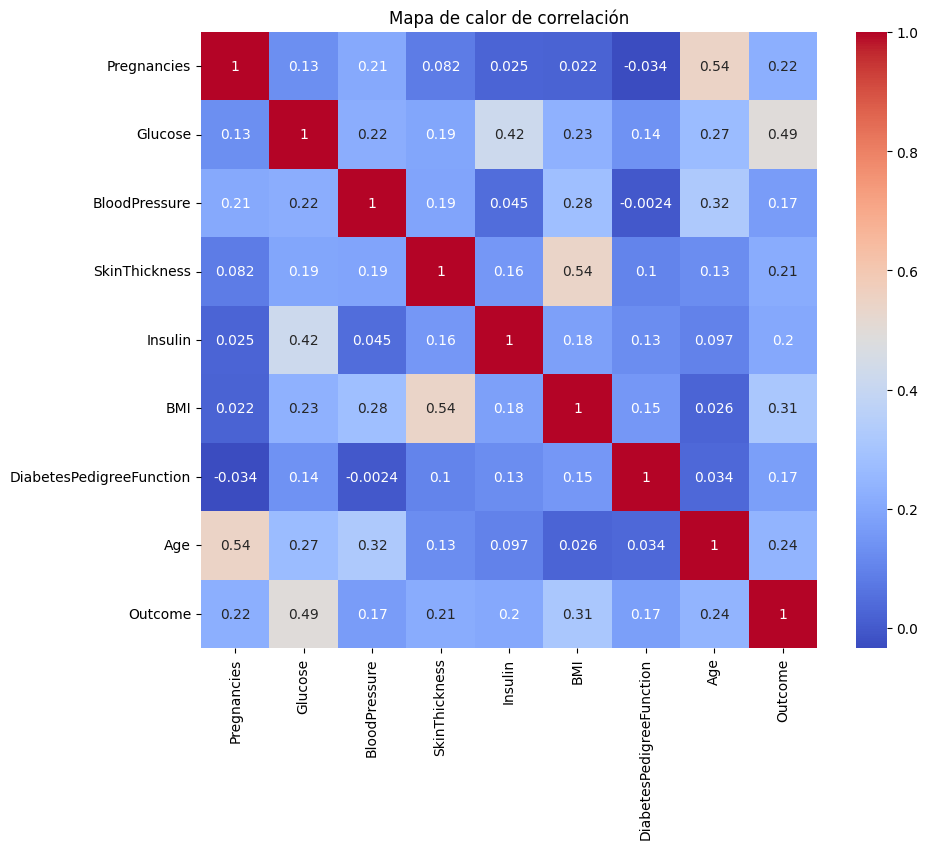


Estadísticas Descriptivas:
                          count        mean        std     min        25%  \
Pregnancies               768.0    3.845052   3.369578   0.000    1.00000   
Glucose                   768.0  121.656250  30.438286  44.000   99.75000   
BloodPressure             768.0   72.386719  12.096642  24.000   64.00000   
SkinThickness             768.0   29.108073   8.791221   7.000   25.00000   
Insulin                   768.0  140.671875  86.383060  14.000  121.50000   
BMI                       768.0   32.455208   6.875177  18.200   27.50000   
DiabetesPedigreeFunction  768.0    0.471876   0.331329   0.078    0.24375   
Age                       768.0   33.240885  11.760232  21.000   24.00000   
Outcome                   768.0    0.348958   0.476951   0.000    0.00000   

                               50%        75%     max    Range     Mode  
Pregnancies                 3.0000    6.00000   17.00   17.000    1.000  
Glucose                   117.0000  140.25000  199.00

In [3]:
# 2. Exploración de Datos

## 2.1 Visualizaciones univariadas
# Generar histogramas para explorar distribuciones de cada columna
for column in diabetes_data.columns[:-1]:
    plt.figure(figsize=(8, 5))
    plt.hist(diabetes_data[column], bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

## 2.1 Visualización multivariada: Diagrama de dispersión
# Explorar relaciones entre Glucose e Insulin según la clase objetivo
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=diabetes_data, x='Glucose', y='Insulin', hue='Outcome', palette='Set1'
)
plt.title('Relación entre Glucose e Insulin')
plt.show()

## 2.2 Mapa de calor de correlación
# Generar un mapa de calor para analizar correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(
    diabetes_data.corr(),
    annot=True,
    cmap="coolwarm",
    square=True
)
plt.title("Mapa de calor de correlación")
plt.show()

# 2.2 Estadísticas descriptivas
# Calcular medidas clave como rango y moda
descriptive_stats = diabetes_data.describe().T
descriptive_stats['Range'] = descriptive_stats['max'] - descriptive_stats['min']
mode_values = diabetes_data.mode().iloc[0]
descriptive_stats['Mode'] = mode_values
print("\nEstadísticas Descriptivas:")
print(descriptive_stats)



In [4]:
# 3. Implementación de Modelos

## Separación de variables independientes y dependientes
X = diabetes_data.drop(columns=['Outcome'])
y = diabetes_data['Outcome']

## 3.1 Escalado de características
# Estandarizar las características para optimizar el rendimiento de XGBoost
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## 3.2 Implementación y ajuste de modelos

### Random Forest con GridSearchCV
rf_params = {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15]}
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='f1'
)
rf_grid.fit(X_train, y_train)

### XGBoost con GridSearchCV
xgb_params = {'n_estimators': [50, 100, 150], 'max_depth': [3, 5, 7]}
xgb_grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    xgb_params,
    cv=5,
    scoring='f1'
)
xgb_grid.fit(X_train, y_train)

## 3.3 Evaluación de Modelos

# Predicciones en el conjunto de prueba
rf_predictions = rf_grid.best_estimator_.predict(X_test)
xgb_predictions = xgb_grid.best_estimator_.predict(X_test)

# Cálculo de métricas de evaluación
metrics = {
    "Accuracy": [
        accuracy_score(y_test, rf_predictions),
        accuracy_score(y_test, xgb_predictions)
    ],
    "Precision": [
        precision_score(y_test, rf_predictions),
        precision_score(y_test, xgb_predictions)
    ],
    "Recall": [
        recall_score(y_test, rf_predictions),
        recall_score(y_test, xgb_predictions)
    ],
    "F1 Score": [
        f1_score(y_test, rf_predictions),
        f1_score(y_test, xgb_predictions)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, rf_grid.best_estimator_.predict_proba(X_test)[:, 1]),
        roc_auc_score(y_test, xgb_grid.best_estimator_.predict_proba(X_test)[:, 1])
    ]
}

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(metrics, index=['Random Forest', 'XGBoost'])
print("\nResultados de los Modelos:")
print(metrics_df)



c:\Users\ivan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\ivan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ivan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:40:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\ivan_\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: 


Resultados de los Modelos:
               Accuracy  Precision    Recall  F1 Score   ROC-AUC
Random Forest  0.746753   0.659574  0.574074  0.613861  0.820556
XGBoost        0.733766   0.632653  0.574074  0.601942  0.818519


In [5]:
# 4. Discusión de resultados
print("\nDiscusión:")
print(f"""
### Discusión de los resultados

#### Desempeño General:
- Random Forest alcanzó un recall de {metrics_df['Recall'][0]:.2f} frente a {metrics_df['Recall'][1]:.2f} de XGBoost.
- XGBoost con {metrics_df['ROC-AUC'][1]:.2f} de ROC-AUC frente a {metrics_df['ROC-AUC'][0]:.2f} de Random Forest.

""")


Discusión:

### Discusión de los resultados

#### Desempeño General:
- Random Forest alcanzó un recall de 0.57 frente a 0.57 de XGBoost.
- XGBoost con 0.82 de ROC-AUC frente a 0.82 de Random Forest.




C:\Users\ivan_\AppData\Local\Temp\ipykernel_36460\2836505649.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  - Random Forest alcanzó un recall de {metrics_df['Recall'][0]:.2f} frente a {metrics_df['Recall'][1]:.2f} de XGBoost.
C:\Users\ivan_\AppData\Local\Temp\ipykernel_36460\2836505649.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  - XGBoost con {metrics_df['ROC-AUC'][1]:.2f} de ROC-AUC frente a {metrics_df['ROC-AUC'][0]:.2f} de Random Forest.
